In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.utils import Sequence
from sklearn.cluster import KMeans
import tensorflow as tf
np.set_printoptions(suppress=True)

In [ ]:
pd.read_csv(os.path.join('../data/mn40','metadata_modelnet40.csv'))['split'].value_counts()

In [2]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Input, Concatenate, Layer, Dense, TimeDistributed, 
                                     MultiHeadAttention, GlobalMaxPooling1D, LSTM, 
                                     LayerNormalization, Dropout, Flatten, Bidirectional)
import tensorflow as tf
import tensorflow_probability as tfp

In [52]:
class MN40Loader(Sequence):
    def __init__(self, data_root, split, N=2096, batch_size=32, datamode='triangles', oversampling=4):
        self.data_root = data_root
        self.batch_size = batch_size
        self.N = N
        
        
        metadata = pd.read_csv(os.path.join(self.data_root, 'metadata_modelnet40val.csv'))
        
        #self.metadata = metadata.loc[metadata.index.repeat(oversampling)]
        self.metadata = metadata.loc[metadata.split==split].sample(frac=1)
        
        
        #self.metadata = self.metadata[self.metadata['class'].isin(['xbox', 'airplane'])]
        self.labels = dict([(idx, label) for label, idx in enumerate(sorted(self.metadata['class'].unique()))])
        
        self.datamode = datamode
        
        self.oversampling = oversampling
        self.resampler = TriangleReSampler(self.oversampling*N)
        
        
    def read_off(self, file):
        off_header = file.readline().strip()
        if 'OFF' == off_header:
            n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
        else:
            n_verts, n_faces, __ = tuple([int(s) for s in off_header[3:].split(' ')])
        verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
        faces = [[int(idx) for idx in file.readline().strip().split(' ')[1:]] for _ in range(n_faces)]
        return tf.constant(verts), tf.ragged.constant(faces)

    def load_file_(self, obj_key):
        with open(os.path.join(self.data_root, 'ModelNet40', obj_key), 'r') as f:
            return self.read_off(f)
        
    def __len__(self):
        return np.ceil(len(self.metadata)/self.batch_size).astype(int)
        
        
    def __getitem__(self, idx):
        bs = self.batch_size
        batch_meta = self.metadata.iloc[idx*bs : (idx+1)*bs]
        
        ys = batch_meta['class'].apply(lambda z: self.labels[z]).values
        
        if self.datamode=='points':
            X = np.zeros((len(batch_meta), self.N, 3))
            mask = np.zeros((len(batch_meta), self.N), dtype=np.int32)

            vs = []

            for i, path in enumerate(batch_meta.object_path):
                verts, _ = self.load_file_(path)

                verts = np.unique(verts, axis=0)

                if len(verts) > self.N:
                    perm = np.random.choice(len(verts), replace=False, size=self.N)
                    verts = verts[perm]

                mask[i, :len(verts)] = np.ones(len(verts))

                X[i, :len(verts)] = verts 


            return [X, mask], ys
        
        elif self.datamode =='triangles':
            vertl, facel = [], []
            
            for i, path in enumerate(batch_meta.object_path):
                verts, faces = self.load_file_(path)
                
                vertl.append(verts), facel.append(faces)
                
            vertrag = tf.ragged.stack(vertl)
            facerag = tf.ragged.stack(facel)
            
            X, M = self.resampler(tf.gather(vertrag, facerag, batch_dims=1).to_tensor())
            
            X = tf.reshape(X, (len(batch_meta)*self.oversampling, self.N, 3))
            M = tf.reshape(M, (len(batch_meta)*self.oversampling, self.N))
            
            return [X,M], np.repeat(ys, self.oversampling)

In [3]:
class TriangleReSampler(Layer):
    def __init__(self, N, max_triangles = 5000, **kwargs):
        super(TriangleReSampler, self).__init__(**kwargs)
        self.N = N
        self.max_triangles = 5000
        
    def compute_output_shape(self, input_shape):
        batch_size = input_shape[0]
        return (batch_size, self.N, input_shape[-1])
    
    def call(self, triangles):
        face_count = tf.shape(triangles)[1]
        batch_sz = tf.shape(triangles)[0]
        
        u = triangles[:,:,0]
        v = triangles[:,:,1]
        w = triangles[:,:,2]
        
        uv = u-v
        wv = w-v

        areas = tf.norm(tf.linalg.cross(uv,wv), axis=-1)
        sidx = tf.argsort(areas, direction='DESCENDING')[:,:self.max_triangles]
        areas = tf.gather(areas, sidx, batch_dims=1)
        
        dist = tfp.distributions.FiniteDiscrete(tf.range(self.max_triangles), probs=areas)
        samp = tfp.distributions.Sample(dist)
        
        samples = tf.transpose(samp.sample((self.N,)))
        samples = tf.gather(sidx, samples, batch_dims=1)
        
        selected_uv = tf.gather(uv, samples, batch_dims=1)
        selected_wv = tf.gather(wv, samples, batch_dims=1)
        selected_v = tf.gather(v, samples, batch_dims=1)
        
        ur = tf.random.uniform((batch_sz, self.N, 1))
        wr = tf.random.uniform((batch_sz, self.N, 1))
        
        coefs = tf.cast(tf.math.ceil(ur+wr)-1, tf.bool)
        
        urf = tf.where(coefs, 1-ur, ur)
        wrf = tf.where(coefs, 1-wr, wr)
        
        sampled_points = selected_v+selected_uv*urf+selected_wv*wrf
        
        
        return sampled_points, tf.ones((batch_sz, self.N), dtype=tf.int32)

In [4]:
class PatchLayer(Layer):
    def __init__(self, patch_count, patch_size, patch_radius, **kwargs):
        super(PatchLayer, self).__init__(**kwargs)
        
        self.patch_size = patch_size
        self.patch_radius = patch_radius
        self.patch_count = patch_count
        
    def compute_output_shape(self, input_shape):
        batch_size = input_shape[0]
        return [(batch_size, self.patch_count, self.patch_size, 3),
                (batch_size, self.patch_count, self.patch_size),
                (batch_size, self.patch_count)
               ]
        
        
    def call(self, points, mask):
        batch_sz = tf.shape(points)[0]
        ## rescale
        mean, variance = tf.nn.moments(points, 1, keepdims=True)
        
        max_var = tf.math.reduce_max(variance, axis=2, keepdims=True)+1e-7
        
        new_points = (points-mean)/tf.sqrt(max_var)
        
        
        # select points
        
        free_points = tf.cast(tf.identity(mask), dtype=tf.float32)
        
        outcomes = tf.range(tf.shape(free_points)[1])
        distances = None
        
        
        ret_points = tf.TensorArray(tf.float32, size=self.patch_count)
        #ret_centers = tf.TensorArray(tf.float32, size=self.patch_count)
        ret_mask = tf.TensorArray(tf.int32, size=self.patch_count)
        ret_patch_mask = tf.TensorArray(tf.int32, size=self.patch_count)
        
        
        
        for i in tf.range(self.patch_count): 
            dist = tfp.distributions.FiniteDiscrete(outcomes, probs=free_points)
            
            samp = tfp.distributions.Sample(dist)
            
            point_idx = tf.transpose(samp.sample(sample_shape=(1,)))
            
            principal_points = tf.gather(new_points, point_idx, axis=1, batch_dims=1)
            
            displacements = principal_points - new_points
            
            distances = tf.norm(displacements, axis = -1)
            
            close_enough_points = tf.less(distances, self.patch_radius) # which points are close enough
            
            valid_points = tf.math.logical_and(close_enough_points, tf.cast(free_points, tf.bool))
            
            d_idx = tf.argsort(distances) # which are the closest
            
            point_sel = tf.gather(valid_points, d_idx, batch_dims=1) # 
            
            taken_points = tf.argsort(tf.cast(point_sel, tf.float32), direction='DESCENDING')[:, :self.patch_size] # take the patch_size closest points
            
            point_mask = tf.cast(tf.gather(point_sel, taken_points, batch_dims=1), tf.int32)
            point_indices = tf.gather(d_idx, taken_points, batch_dims = 1)
            
            batch_points = tf.gather(new_points, point_indices, batch_dims = 1)
            
            #bmean, _ = tf.nn.moments(batch_points, 1, keepdims=True)
            
            #batch_points = batch_points - bmean

        
            used = tf.einsum("bce,bc->be",
                           tf.one_hot(point_indices, tf.shape(points)[1]), 
                           tf.cast(point_mask, tf.float32))
            
            was_updated = tf.cast(tf.greater(tf.reduce_sum(used, -1), 0.5), tf.int32)
            
            free_points = free_points-used
        
            
            
            ret_points = ret_points.write(i, batch_points)
            #ret_centers = ret_centers.write(i, tf.squeeze(bmean))
            ret_mask = ret_mask.write(i, point_mask)
            ret_patch_mask = ret_patch_mask.write(i, was_updated)
        
        

        return  tf.transpose(ret_points.stack(), perm=[1,0,2,3]), \
                tf.transpose(ret_mask.stack(), perm=[1,0,2]), \
                tf.transpose(ret_patch_mask.stack(), perm=[1,0])

In [5]:
class CLSPrepadLayer(Layer):
    def __init__(self, patch_size, d, **kwargs):
        super(CLSPrepadLayer, self).__init__(**kwargs)
        self.patch_size = patch_size
        self.d = d
        
    def build(self, in_shape):
        self.class_patch_emb = self.add_weight("cls_pat_emb", shape=(1, 1, self.patch_size, 3))
        #self.class_cent_emb = self.add_weight("cls_cnt_emb", shape=(1, 3))
        
    def call(self, patches, point_mask, patch_mask):
        batch_size = tf.shape(patches)[0]

        class_emb = tf.broadcast_to(
            self.class_patch_emb, [batch_size, 1, self.patch_size, 3]
        )
        """
        class_cent_emb = tf.broadcast_to(
            self.class_cent_emb, [batch_size, 1, 3]
        )
        """
        

        from_mask = tf.concat([tf.ones((batch_size, 1), dtype=tf.int32), patch_mask], axis=1)
        to_mask = tf.concat([tf.zeros((batch_size, 1), dtype=tf.int32), patch_mask], axis=1)
        
        cls_to_cls_pre = tf.concat([tf.ones((batch_size, 1), dtype=tf.int32), tf.zeros_like(patch_mask)], axis=1)
        
        cross_mask = tf.einsum('bi,bj->bij', from_mask, to_mask)
        cls_to_cls_mask = tf.einsum('bi,bj->bij', cls_to_cls_pre, cls_to_cls_pre)
        
        
        cls_point_mask = tf.ones((batch_size, 1, self.patch_size), dtype=tf.int32)
        
        return tf.concat([class_emb, patches], axis=1), \
                tf.concat([cls_point_mask, point_mask], axis=1), \
                cross_mask + cls_to_cls_mask

In [6]:
class LDDMMSelfAttentionLayer(Layer):
    def __init__(self, emb_dim, **kwargs):
        super(LDDMMSelfAttentionLayer, self).__init__(**kwargs)
        self.emb_dim = emb_dim
        
        self.Qs = TimeDistributed(Dense(emb_dim))
        self.Ks = TimeDistributed(Dense(emb_dim))
        self.Vs = TimeDistributed(Dense(emb_dim))
        
        self.center_attention = MultiHeadAttention(1, emb_dim)
        
    def call(self, patches, point_mask, attention_mask):

        # calculate shape scores
        
        return patches
        

In [7]:
class PoolingSelfAttentionLayer(Layer):
    def __init__(self, emb_dim, **kwargs):
        super(PoolingSelfAttentionLayer, self).__init__(**kwargs)
        self.emb_dim = emb_dim
        
        self.att1 = MultiHeadAttention(1, self.emb_dim, value_dim=128)
        
    def call(self, patches, point_mask, attention_mask):
        float_mask = tf.cast(point_mask, tf.float32)
        ## zero out with mask
        masked = patches*float_mask[:,:,:,tf.newaxis]
        sums = tf.reduce_sum(patches, axis=2)
        weights = (tf.reduce_sum(float_mask, axis=-1, keepdims=True)+1e-7)
        
        means = sums/weights
        
        
        return self.att1(means, means, attention_mask=attention_mask)

In [8]:
class LSTMSelfAttentionLayer(Layer):
    def __init__(self, emb_dim, **kwargs):
        super(LSTMSelfAttentionLayer, self).__init__(**kwargs)
        self.emb_dim = emb_dim
        
        self.lstm = TimeDistributed(LSTM(emb_dim, recurrent_activation='tanh'))
        
        self.att = MultiHeadAttention(4, emb_dim)
        
    def call(self, patches, point_mask, att_mask, training):
        
        reprs = self.lstm(patches, mask=tf.cast(point_mask, tf.bool), training=training)
        
        return self.att(reprs, reprs, attention_mask=att_mask)

# Shape transformer 1

In [9]:
class TransformerBlock(Layer):
    def __init__(self, embedding_dim, head_count, dropout, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.attention_layer = MultiHeadAttention(head_count, embedding_dim, dropout=dropout)
        
        self.LN1 = LayerNormalization(epsilon=1e-6)
        self.LN2 = LayerNormalization(epsilon=1e-6)
        self.dropout = Dropout(dropout)
        
    def build(self, input_shape):
        super(TransformerBlock, self).build(input_shape)
        insize = input_shape[2]
        
        self.MLP = Sequential([
            Dense(2*insize, activation=tf.keras.activations.gelu),
            Dense(insize)
        ])
        self.MLP.build(input_shape)
        
    def call(self, inputs, mask, training, return_attention_scores=False):
        P = self.LN1(inputs)
        if not return_attention_scores:
            h1 = self.dropout(self.attention_layer(P, P, attention_mask = mask) + P)

            return self.MLP(self.LN2(h1)) + h1
        else:
            att, scores = self.attention_layer(P, P, attention_mask = mask, return_attention_scores=True)
            
            h1 = self.dropout(att + P)

            return self.MLP(self.LN2(h1)) + h1, scores

        

In [10]:
class ShapeTransformer1(Model):
    def __init__(self, N, patch_count, patch_size, patch_radius, attention_dim, patch_emb_dim, with_resampler=False):
        super(ShapeTransformer1, self).__init__()
        self.patch_count = patch_count
        self.N = N
        self.with_resampler = with_resampler
        self.patch_emb_dim = patch_emb_dim
        
        if with_resampler:
            self.resampler = TriangleReSampler(N)
        
        self.patch_layer = PatchLayer(patch_count-1, patch_size, patch_radius)
        self.seqproc = CLSPrepadLayer(patch_size, 3)
        
        self.patch_trans = TimeDistributed(Dense(patch_emb_dim))
        
        
        self.transformerblock1 = TransformerBlock(attention_dim, 2, 0.1)
        self.transformerblock2 = TransformerBlock(attention_dim, 2, 0.1)
        self.transformerblock3 = TransformerBlock(attention_dim, 2, 0.1)
        
        self.LN = LayerNormalization(epsilon=1e-6)
        
        self.dense1 = Dense(1024, activation = 'relu')
        self.dense2 = Dense(40, activation='softmax')

    def summary(self):
        if self.with_resampler:
            x = Input(shape=(None, 3, 3), name='triangles')
            model = Model(inputs=[x, faces], outputs=self.call(x, False))
            return model.summary()
        else:
            x = Input(shape=(self.N, 3), name='points')
            mask = Input(shape=(self.N), name='mask')
            model = Model(inputs=[x, mask], outputs=self.call([x,mask], False))
            return model.summary()
    
    
    def call(self, datin, training):
        if self.with_resampler:
            triangles = datin
            seq, mask = self.resampler(triangles)
        else:
            seq, mask = datin 
    
        patches, point_mask, patch_mask = self.patch_layer(seq, mask)
    
        patches, point_mask, attention_mask = self.seqproc(patches, point_mask, patch_mask)
        
        P = TimeDistributed(Flatten())(patches)
        P = self.patch_trans(P)
        
        x = self.transformerblock1(P, attention_mask, training)
        
        x = self.transformerblock2(x, attention_mask, training)
        
        cls = self.LN(x[:, 0])
        
        x = self.dense1(cls)
        
        pred = self.dense2(x)
    
        return pred

In [11]:
def create_model1(N, patch_count, patch_size, patch_radius, attention_dim, patch_emb_dim, with_resampler=False):
    model = ShapeTransformer1(N, patch_count, patch_size, patch_radius, attention_dim, patch_emb_dim, with_resampler=with_resampler)
    
    if with_resampler:
        model.build(input_shape=(None, None, 3, 3))
    else:
        model.build(input_shape=[(None, N, 3), (None, N)])
    
    model.compile('adam', 'sparse_categorical_crossentropy', metrics='accuracy')
    
    return model

In [12]:
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm

In [13]:
trainfile = np.load("traindata_medium2048.npz")
X, M, y = trainfile['X'], trainfile['M'], trainfile['y']

testfile = np.load("testdata_small2048.npz")
Xt, Mt, yt = testfile['X'], testfile['M'], testfile['y']

In [14]:
cws = dict(enumerate(compute_class_weight('balanced', y=y, classes=range(40))))

In [66]:
model = create_model1(8192, 84, 84, 0.3, 64, 256)

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
points (InputLayer)             [(None, 2048, 3)]    0                                            
__________________________________________________________________________________________________
mask (InputLayer)               [(None, 2048)]       0                                            
__________________________________________________________________________________________________
patch_layer_1 (PatchLayer)      ((None, 127, None, 3 0           points[0][0]                     
                                                                 mask[0][0]                       
__________________________________________________________________________________________________
cls_prepad_layer_1 (CLSPrepadLa ((None, 128, 16, 3), 48          patch_layer_1[0][0]          

In [28]:
model.fit([X,M], y, validation_data=([Xt, Mt], yt), epochs=8*50, class_weight=cws, batch_size=64)

Epoch 1/400
  15/1231 [..............................] - ETA: 12:38 - loss: 4.7626 - accuracy: 0.0146

KeyboardInterrupt: 

# Shape Transformer 2

In [13]:
class ShapeTransformer2(Model):
    def __init__(self, N, patch_count, patch_size, patch_radius, attention_dim, patch_emb_dim, with_resampler=False):
        super(ShapeTransformer2, self).__init__()
        self.patch_count = patch_count
        self.N = N
        self.with_resampler = with_resampler
        self.patch_emb_dim = patch_emb_dim
        
        if with_resampler:
            self.resampler = TriangleReSampler(N)
        
        self.patch_layer = PatchLayer(patch_count-1, patch_size, patch_radius)
        self.seqproc = CLSPrepadLayer(patch_size, 3)
        
        self.patch_summarizer = TimeDistributed(Bidirectional(LSTM(patch_emb_dim//2)), name="PatchLSTM")
        
        
        self.transformerblock1 = TransformerBlock(attention_dim, 2, 0.1, name="t1")
        self.transformerblock2 = TransformerBlock(attention_dim, 2, 0.1, name="t2")
        self.transformerblock3 = TransformerBlock(attention_dim, 2, 0.1)
        
        self.LN = LayerNormalization(epsilon=1e-6)
        
        self.dense1 = Dense(1024, activation = 'relu')
        self.dense2 = Dense(40, activation='softmax')

    def summary(self):
        if self.with_resampler:
            x = Input(shape=(None, 3, 3), name='triangles')
            model = Model(inputs=[x, faces], outputs=self.call(x, False))
            return model.summary()
        else:
            x = Input(shape=(self.N, 3), name='points')
            mask = Input(shape=(self.N), name='mask')
            model = Model(inputs=[x, mask], outputs=self.call([x,mask], False))
            return model.summary()
    
    
    def call(self, datin, training):
        if self.with_resampler:
            triangles = datin
            seq, mask = self.resampler(triangles)
        else:
            seq, mask = datin 
    
        patches, point_mask, patch_mask = self.patch_layer(seq, mask)
    
        patches, point_mask, attention_mask = self.seqproc(patches, point_mask, patch_mask)
        
        P = self.patch_summarizer(patches, point_mask)
        
        x = self.transformerblock1(P, attention_mask, training)
        
        x = self.transformerblock2(x, attention_mask, training)
        
        cls = self.LN(x[:, 0])
        
        x = self.dense1(cls)
        
        pred = self.dense2(x)
    
        return pred

In [14]:
def create_model2(N, patch_count, patch_size, patch_radius, attention_dim, patch_emb_dim, with_resampler=False):
    model = ShapeTransformer2(N, patch_count, patch_size, patch_radius, attention_dim, patch_emb_dim, with_resampler=with_resampler)
    
    if with_resampler:
        model.build(input_shape=(None, None, 3, 3))
    else:
        model.build(input_shape=[(None, N, 3), (None, N)])
    
    model.compile('adam', 'sparse_categorical_crossentropy', metrics='accuracy')
    
    return model

In [ ]:
model = create_model2(512, 64, 32, 0.3, 64, 256)

In [ ]:
model.summary()

In [ ]:
model.fit([X,M], y, validation_data=([Xt, Mt], yt), epochs=8*50, class_weight=cws, batch_size=64)

# Shape Transformer 3

In [15]:
class PatchEncoder(Layer):
    def __init__(self, emb_dim, **kwargs):
        super(PatchEncoder, self).__init__(**kwargs)
        self.flattener = TimeDistributed(Flatten())
        self.point_projection = TimeDistributed(Dense(emb_dim))
        self.positional_encoder = TimeDistributed(Dense(emb_dim))
        
    def call(self, sequence, point_mask):
        means = tf.einsum('bmpd,bmp->bmd', sequence, tf.cast(point_mask, tf.float32))
        
        exmeans = tf.expand_dims(means, 2)
        
        centered = sequence-exmeans
        
        flattened = self.flattener(centered)
        
        shape_encoding = self.point_projection(flattened)
        
        positional_encoding = self.positional_encoder(means)
        
        return shape_encoding+positional_encoding
        
        

In [16]:
class ShapeTransformer3(Model):
    def __init__(self, N, patch_count, patch_size, patch_radius, attention_dim, patch_emb_dim, with_resampler=False):
        super(ShapeTransformer3, self).__init__()
        self.patch_count = patch_count
        self.N = N
        self.with_resampler = with_resampler
        self.patch_emb_dim = patch_emb_dim
        
        if with_resampler:
            self.resampler = TriangleReSampler(N)
        
        self.patch_layer = PatchLayer(patch_count-1, patch_size, patch_radius)
        self.seqproc = CLSPrepadLayer(patch_size, 3)
        self.patch_encoder = PatchEncoder(patch_emb_dim)
        
        
        self.transformerblock1 = TransformerBlock(attention_dim, 2, 0.1, name="t1")
        self.transformerblock2 = TransformerBlock(attention_dim, 2, 0.1, name="t2")
        self.transformerblock3 = TransformerBlock(attention_dim, 2, 0.1)
        
        self.LN = LayerNormalization(epsilon=1e-6)
        
        self.dense1 = Dense(1024, activation = 'relu')
        self.dense2 = Dense(40, activation='softmax')

    def summary(self):
        if self.with_resampler:
            x = Input(shape=(None, 3, 3), name='triangles')
            model = Model(inputs=[x, faces], outputs=self.call(x, False))
            return model.summary()
        else:
            x = Input(shape=(self.N, 3), name='points')
            mask = Input(shape=(self.N), name='mask')
            model = Model(inputs=[x, mask], outputs=self.call([x,mask], False))
            return model.summary()
    
    
    def call(self, datin, training):
        if self.with_resampler:
            triangles = datin
            seq, mask = self.resampler(triangles)
        else:
            seq, mask = datin 
    
        patches, point_mask, patch_mask = self.patch_layer(seq, mask)
    
        patches, point_mask, attention_mask = self.seqproc(patches, point_mask, patch_mask)
        
        P = self.patch_encoder(patches, point_mask)
        
        x = self.transformerblock1(P, attention_mask, training)
        
        x = self.transformerblock2(x, attention_mask, training)
        
        cls = self.LN(x[:, 0])
        
        x = self.dense1(cls)
        
        pred = self.dense2(x)
    
        return pred

In [18]:
def create_model3(N, patch_count, patch_size, patch_radius, attention_dim, patch_emb_dim, with_resampler=False):
    model = ShapeTransformer3(N, patch_count, patch_size, patch_radius, attention_dim, patch_emb_dim, with_resampler=with_resampler)
    
    if with_resampler:
        model.build(input_shape=(None, None, 3, 3))
    else:
        model.build(input_shape=[(None, N, 3), (None, N)])
    
    model.compile('adam', 'sparse_categorical_crossentropy', metrics='accuracy')
    
    return model

In [ ]:
model = create_model3(512, 64, 32, 0.3, 64, 256)

In [ ]:
model.summary()

In [ ]:
model.fit([X,M], y, validation_data=([Xt, Mt], yt), epochs=8*50, class_weight=cws, batch_size=64)

# Hyperparameter estimation

In [17]:
class ShapeTransformer(Model):
    def __init__(self, N, transformer_count, transformer_dropout, 
                         t_headcount,
                         patch_count, patch_size, 
                         patch_radius, attention_dim, 
                         patch_emb_dim, with_resampler=False):
        super(ShapeTransformer, self).__init__()

        self.patch_count = patch_count
        self.N = N
        self.with_resampler = with_resampler
        self.patch_emb_dim = patch_emb_dim
        self.headcount = t_headcount
        
        if with_resampler:
            self.resampler = TriangleReSampler(N)
        
        self.patch_layer = PatchLayer(patch_count-1, patch_size, patch_radius)
        self.seqproc = CLSPrepadLayer(patch_size, 3)
        
        self.patch_trans = TimeDistributed(Dense(patch_emb_dim))
        
        assert transformer_count > 0
        self.attblocks = [TransformerBlock(attention_dim, t_headcount, transformer_dropout, name=f"transformer_block_{i}") for i in range(transformer_count)]
        
        self.LN = LayerNormalization(epsilon=1e-6)
        
        self.dense1 = Dense(2048, activation = 'relu')
        self.dropout1 = Dropout(0.2)
        self.dense2 = Dense(1024)
        self.dense3 = Dense(40, activation='softmax')

    def summary(self):
        if self.with_resampler:
            x = Input(shape=(None, 3, 3), name='triangles')
            model = Model(inputs=[x, faces], outputs=self.call(x, False))
            return model.summary()
        else:
            x = Input(shape=(self.N, 3), name='points')
            mask = Input(shape=(self.N), name='mask')
            model = Model(inputs=[x, mask], outputs=self.call([x,mask], False))
            return model.summary()
    
    
    def call(self, datin, training):
        if self.with_resampler:
            triangles = datin
            seq, mask = self.resampler(triangles)
        else:
            seq, mask = datin 
    
        patches, point_mask, patch_mask = self.patch_layer(seq, mask)
    
        patches, point_mask, attention_mask = self.seqproc(patches, point_mask, patch_mask)
        
        P = TimeDistributed(Flatten())(patches)
        x = self.patch_trans(P)
        
        for block in self.attblocks:
            x = block(x, attention_mask, training)
        
        cls = self.LN(x[:, 0])
        
        x = self.dense1(cls)
        x = self.dropout1(x)
        
        x = self.dense2(x)
        
        pred = self.dense3(x)
    
        return pred
    
    def inspect(self, datin):
        if self.with_resampler:
            triangles = datin
            seq, mask = self.resampler(triangles)
        else:
            seq, mask = datin 
    
        patches, point_mask, patch_mask = self.patch_layer(seq, mask)
    
        patches, point_mask, attention_mask = self.seqproc(patches, point_mask, patch_mask)
        
        P = TimeDistributed(Flatten())(patches)
        x = self.patch_trans(P)
        
        bs = tf.shape(seq)[0]
        
        attscores = np.zeros((len(self.attblocks), bs, self.headcount, self.patch_count, self.patch_count))
        
        for i, block in enumerate(self.attblocks):
            x, score = block(x, attention_mask, False, return_attention_scores = True)
            attscores[i] = score
        
        cls = self.LN(x[:, 0])
        
        x = self.dense1(cls)
        x = self.dropout1(x)
        
        x = self.dense2(x)
        
        pred = self.dense3(x)
    
        return pred, attscores, patches, point_mask, attention_mask

In [18]:
def create_model(N, transformer_count, transformer_dropout, 
                 t_headcount, 
                 patch_count, patch_size, 
                 patch_radius, attention_dim, patch_emb_dim, optimizer='adam', with_resampler=False):
    model = ShapeTransformer(N,transformer_count, transformer_dropout, 
                                t_headcount, patch_count, 
                                patch_size, patch_radius, attention_dim, 
                                patch_emb_dim, with_resampler=with_resampler)
    
    if with_resampler:
        model.build(input_shape=(None, None, 3, 3))
    else:
        model.build(input_shape=[(None, N, 3), (None, N)])
    
    model.compile(optimizer, 'sparse_categorical_crossentropy', metrics='accuracy')
    
    return model

In [19]:
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers.schedules import CosineDecay
from sklearn.model_selection import train_test_split
import keras_tuner as kt

In [20]:
def create_hypermodel1(hp, *, log_dir, N):
    hN = hp.Fixed("N", N)
    
    htrans_count = hp.Int("transformer_count", min_value=1, max_value=6)
    
    htransformer_dropout = hp.Float("transformer_dropout", min_value=0, max_value=0.5, step=0.1)
    htransformer_headcount = hp.Int("transformer_headcount", min_value=1, max_value=4)
    
    hpatch_count = hp.Int("patch_count", min_value=8, max_value=N//16, step=8)
    hpatch_size =  N//hpatch_count
    
    hpatch_radius = hp.Fixed("patch_radius", 0.2)
    
    hattention_dim = hp.Int("attention_dim", min_value=16, max_value=512, step=16)
    hpatch_emb_dim = hp.Int("patch_dim", min_value=16, max_value=512, step=16)

    hlr = hp.Float("learning_rate", min_value=5e-5, max_value=5e-3, sampling='log')

    
    if hp.Boolean("use_decay"):
        hlr = CosineDecay(hlr, 1500)
    
    otim = Adam(learning_rate=hlr)
    
    return create_model(
        N=hN,
        transformer_count = htrans_count,
        transformer_dropout = htransformer_dropout,
        t_headcount = htransformer_headcount,
        patch_count = hpatch_count,
        patch_size = hpatch_size,
        patch_radius = hpatch_radius,
        attention_dim = hattention_dim,
        patch_emb_dim = hpatch_emb_dim,
        optimizer = otim,
        with_resampler=False
    )

In [21]:
def tuning_run(N, factory):
    
    run_name = input("Run name: ")
    log_dir = os.path.join("logs", run_name)
    
    if not os.path.exists(log_dir):
        os.mkdir(log_dir)
    
    model_factory = lambda hp: factory(hp, log_dir=log_dir, N=N)
    
    trainfile = np.load(f"traindata_medium{N}NEW.npz")
    X, M, y = trainfile['X'], trainfile['M'], trainfile['y']

    valfile = np.load(f"validationdata_small{N}.npz")
    Xv, Mv, yv = valfile['X'], valfile['M'], valfile['y']

    
    cws = dict(enumerate(compute_class_weight('balanced', y=y, classes=range(40))))
    
    
    callbacks = [
        EarlyStopping(monitor="val_loss", patience=3, min_delta=0.01),
        TensorBoard(log_dir, histogram_freq=1)
    ]

    tuner = kt.Hyperband(
        model_factory,
        objective='val_loss',
        factor=3,
        max_epochs=20,
        directory=os.path.join(log_dir, "tuner_dir"),
        project_name="ST1",
    )
    
    
    
    tuner.search_space_summary()


    tuner.search(
        x=[X,M], y=y, 
        validation_data=([Xv, Mv], yv),
        callbacks=callbacks,
        class_weight=cws,
        batch_size=64
    )
    
    return tuner

In [29]:
tun = tuning_run(2048, create_hypermodel1)

Run name: rmsprop
INFO:tensorflow:Reloading Oracle from existing project logs\rmsprop\tuner_dir\ST1\oracle.json
INFO:tensorflow:Reloading Tuner from logs\rmsprop\tuner_dir\ST1\tuner0.json
Search space summary
Default search space size: 11
N (Fixed)
{'conditions': [], 'value': 2048}
transformer_count (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 6, 'step': 1, 'sampling': None}
transformer_dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
transformer_headcount (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
patch_count (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
patch_radius (Fixed)
{'conditions': [], 'value': 0.2}
attention_dim (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 512, 'step': 16, 'sampling': None}
patch_dim (Int)
{'default': None, 'conditions': [

KeyboardInterrupt: 

In [84]:
tun.get_best_hyperparameters(1)[0]["learning_rate"]

9.138284416269327e-05

## LR estimation

In [22]:
def create_hypermodellr(hp, *, log_dir, N):
    hN = hp.Fixed("N", N)
    
    htrans_count = hp.Fixed("transformer_count", 3)
    
    htransformer_dropout = hp.Fixed("transformer_dropout", 0.1)
    htransformer_headcount = hp.Fixed("transformer_headcount", 3)
    
    hpatch_count = hp.Fixed("patch_count", 128)
    hpatch_size =  N//hpatch_count
    
    hpatch_radius = hp.Fixed("patch_radius", 0.2)
    
    hattention_dim = hp.Fixed("attention_dim", 84)
    hpatch_emb_dim = hp.Fixed("patch_dim", 96)

    hlr = hp.Float("learning_rate", min_value=5e-5, max_value=5e-3, sampling='log')
    hmom = hp.Float("momentum", min_value=1e-5, max_value=1e-2, sampling='log')
    
    if hp.Boolean("use_decay"):
        hlr = CosineDecay(hlr, 500)
    
    otim = RMSprop(learning_rate=hlr, momentum=hmom)
    
    return create_model(
        N=hN,
        transformer_count = htrans_count,
        transformer_dropout = htransformer_dropout,
        t_headcount = htransformer_headcount,
        patch_count = hpatch_count,
        patch_size = hpatch_size,
        patch_radius = hpatch_radius,
        attention_dim = hattention_dim,
        patch_emb_dim = hpatch_emb_dim,
        optimizer = otim,
        with_resampler=False
    )

In [33]:
tuning_run(2048, create_hypermodellr)

Trial 27 Complete [00h 58m 05s]
val_loss: 0.7422627210617065

Best val_loss So Far: 0.7010486721992493
Total elapsed time: 12h 56m 47s

Search: Running Trial #28

Hyperparameter    |Value             |Best Value So Far 
N                 |2048              |2048              
transformer_count |3                 |3                 
transformer_dro...|0.1               |0.1               
transformer_hea...|3                 |3                 
patch_count       |128               |128               
patch_radius      |0.2               |0.2               
attention_dim     |84                |84                
patch_dim         |96                |96                
learning_rate     |0.0025842         |0.00023467        
momentum          |0.00016889        |4.6245e-05        
use_decay         |True              |False             
tuner/epochs      |20                |20                
tuner/initial_e...|0                 |7                 
tuner/bracket     |0                 |1

KeyboardInterrupt: 

In [23]:
model = create_model(        
    N=2048,
    transformer_count = 3,
    transformer_dropout = 0.1,
    t_headcount = 3,
    patch_count = 128,
    patch_size = 2048//128,
    patch_radius = 0.2,
    attention_dim = 84,
    patch_emb_dim = 96,
    optimizer = Adam(0.0007),
    with_resampler=False)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [24]:
trainfile = np.load("traindata_medium2048NEW.npz")
X, M, y = trainfile['X'], trainfile['M'], trainfile['y']

valfile = np.load("validationdata_small2048.npz")
Xv, Mv, yv = valfile['X'], valfile['M'], valfile['y']

testfile = np.load("testdata_small2048.npz")
Xt, Mt, yt = testfile['X'], testfile['M'], testfile['y']

cws = dict(enumerate(compute_class_weight('balanced', y=y, classes=range(40))))

In [25]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, min_delta=0.01, restore_best_weights=True)
]

model.fit([X,M], y, 
          validation_data=([Xv, Mv], yv), 
          epochs=50, class_weight=cws, batch_size=256, callbacks=callbacks)

Epoch 1/50
241/241 [==============================] - 144s 576ms/step - loss: 1.9526 - accuracy: 0.4515 - val_loss: 1.2603 - val_accuracy: 0.6155
Epoch 2/50
241/241 [==============================] - 522s 2s/step - loss: 1.1924 - accuracy: 0.6535 - val_loss: 0.9646 - val_accuracy: 0.6890
Epoch 3/50
241/241 [==============================] - 508s 2s/step - loss: 0.9696 - accuracy: 0.7138 - val_loss: 0.9346 - val_accuracy: 0.7150
Epoch 4/50
241/241 [==============================] - 309s 1s/step - loss: 0.8546 - accuracy: 0.7431 - val_loss: 0.7895 - val_accuracy: 0.7522
Epoch 5/50
241/241 [==============================] - 338s 1s/step - loss: 0.7561 - accuracy: 0.7686 - val_loss: 0.7597 - val_accuracy: 0.7736
Epoch 6/50
241/241 [==============================] - 270s 1s/step - loss: 0.6987 - accuracy: 0.7847 - val_loss: 0.7255 - val_accuracy: 0.7727
Epoch 7/50
241/241 [==============================] - 229s 950ms/step - loss: 0.6341 - accuracy: 0.8045 - val_loss: 0.7226 - val_accuracy: 

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [28]:
preds = model.predict([Xt, Mt])

In [37]:
conmat = confusion_matrix(yt, np.argmax(preds, axis=1))

<AxesSubplot:>

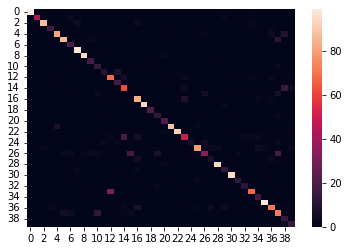

In [38]:
sns.heatmap(conmat)

In [59]:
xl, ml, yl = Xt[:16], Mt[:16], yt[:16]

In [60]:
pred, atts, patches, pontmask, attmask = model.inspect([xl, ml])

In [61]:
from matplotlib import cm

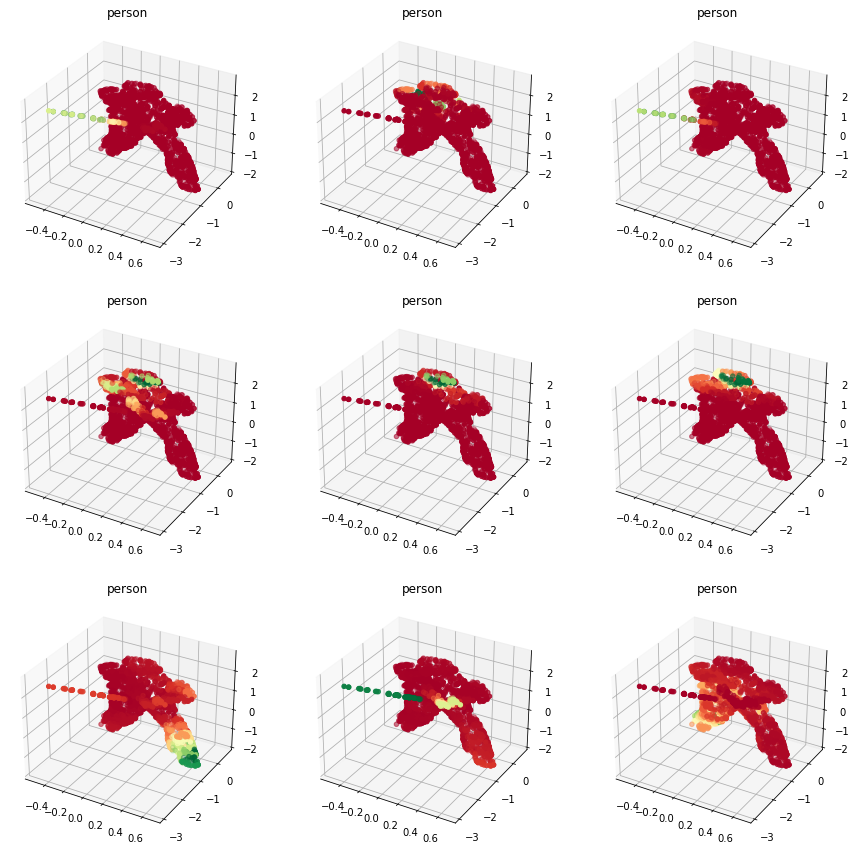

In [63]:
fig = plt.figure()
fig.set_size_inches(15,15)
ax = []
pw = 14

p = patches[pw, 1:]
for layer in range(3):
    for head in range(3):
    
        ax = fig.add_subplot(3,3,3*layer+head+1, projection='3d')

        
        colors = atts[layer, pw, head, 0, 1:]

        colors /= max(colors)
        ax.set_title(next(k for (k,v) in mn.labels.items() if v == yl[pw]))

        for j in range(127):
            ax.scatter(*p[j].numpy().T, c=plt.cm.RdYlGn(np.repeat(colors[j], 16)))

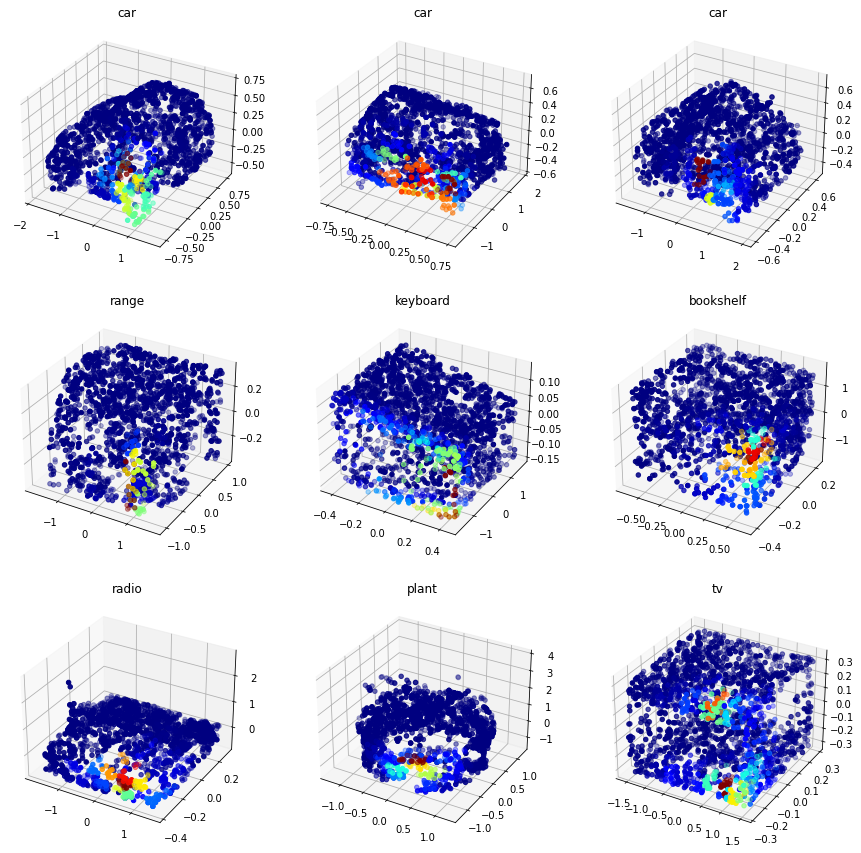

In [145]:
fig = plt.figure()
fig.set_size_inches(15,15)
ax = []
h = 1
for i in range(9):
    
    ax = fig.add_subplot(3,3,i+1, projection='3d')
    
    p = patches[i, 1:]
    colors = atts[h, i, 0, 0, 1:]
    
    colors /= max(colors)
    ax.set_title(next(k for (k,v) in mn.labels.items() if v == yl[i]))
    
    for j in range(127):
        ax.scatter(*p[j].numpy().T, c=plt.cm.jet(np.repeat(colors[j], 16)))